# About this notebook

This notebook explores methods of integrating fire occurrence predictions with economic data in order to estimate fire risk.
The economic data available to us are the value of structures, vehicles, and structure contents for San Diego county in the years 2011 and 2019. Here we explore predictions for the 2007 fire season using economic data from 2011 as a proxy for economic data in 2007, since the actual data from 2007 is not available to us.

The logistic regression model actually produces probabilities of class labels, so this notebook additionally explores the impact of picking different prediction thresholds (e.g. if probability is above X then assign to the positive class).

## Loading the fire predictions

In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style('darkgrid')

In [2]:
%%time
import pandas as pd
# import pyarrow.parquet as pq
from fastparquet import ParquetFile
import s3fs
import boto3
from tqdm.notebook import tqdm

YEAR = 2007
s3_keys = []
prediction_url = "wildfire_capstone/logistic_regression_predictions/with_probs/"\
                 "year={year}/weight={weight}/month={month}/"
s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')
s3_keys = [(item.key, weight)
           for weight in [1000, 10000]
           for month in [str(m).zfill(2) for m in range(1, 13)]
           for item in s3_resource.Bucket('dse-cohort5-group5').objects.filter(
               Prefix=prediction_url.format(year=YEAR, weight=weight, month=month))
           if item.key.endswith('.parquet') or True]
display(s3_keys[:3])
s3 = s3fs.S3FileSystem()
s3.invalidate_cache()
myopen = s3.open
s3_url = 's3://dse-cohort5-group5/{}'
# Going to spawn multiple threads to download concurrently,
# so define a function here
def get_dataframe_from_s3(key, weight):
    return (ParquetFile(s3_url.format(key), open_with=myopen).to_pandas(), weight)

[('wildfire_capstone/logistic_regression_predictions/with_probs/year=2007/weight=1000/month=01/part-00093-930571dc-c0f2-46d6-b9ad-c5c22ea89ff6.c000.gz.parquet',
  1000),
 ('wildfire_capstone/logistic_regression_predictions/with_probs/year=2007/weight=1000/month=01/part-00200-930571dc-c0f2-46d6-b9ad-c5c22ea89ff6.c000.gz.parquet',
  1000),
 ('wildfire_capstone/logistic_regression_predictions/with_probs/year=2007/weight=1000/month=01/part-00201-930571dc-c0f2-46d6-b9ad-c5c22ea89ff6.c000.gz.parquet',
  1000)]

Wall time: 3.96 s


In [11]:
import concurrent.futures
import urllib.request

WORKERS = 36
dfs = []

# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor(max_workers=WORKERS) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = [executor.submit(get_dataframe_from_s3, key, weight) for (key, weight) in s3_keys]
    for future in tqdm(concurrent.futures.as_completed(future_to_url)):
        dfs.append(future.result())

In [13]:
num_rows = sum(len(df) for (df, weight) in dfs)
num_rows

649700

In [14]:
dfs[0][0].head()

,date,latitude,longitude,fire_occurred,acres_burned,year,day,probability.type,probability.size,probability.indices,probability.values
0,1167609600000000000,32.566667,-117.058333,0,NaN,2007,01,1,NaN,[],"[0.7778060123449018, 0.2221939876550982]"
1,1167609600000000000,32.900000,-116.600000,0,NaN,2007,01,1,NaN,[],"[0.8787370641425577, 0.12126293585744218]"
2,1167609600000000000,33.316667,-116.850000,0,NaN,2007,01,1,NaN,[],"[0.987887035342746, 0.01211296465725403]"
3,1167609600000000000,33.316667,-116.683333,0,NaN,2007,01,1,NaN,[],"[0.9903496924876596, 0.009650307512340377]"
4,1167696000000000000,32.650000,-116.516667,0,NaN,2007,02,1,NaN,[],"[0.8885636564851243, 0.11143634351487582]"


In [15]:
%%time
for (df, weight) in dfs:
    df.date = pd.to_datetime(df.date)
    df.set_index(['date', 'latitude', 'longitude'], inplace=True)
    df['weight'] = weight
    df['probability_of_fire'] = df['probability.values'].apply(lambda x: x[1])
dfs[0][0].head()

Wall time: 21.2 s


fire_occurred  acres_burned  year day  \
date       latitude  longitude                                            
2007-01-01 32.566667 -117.058333              0           NaN  2007  01   
           32.900000 -116.600000              0           NaN  2007  01   
           33.316667 -116.850000              0           NaN  2007  01   
                     -116.683333              0           NaN  2007  01   
2007-01-02 32.650000 -116.516667              0           NaN  2007  02   

                                  probability.type  probability.size  \
date       latitude  longitude                                         
2007-01-01 32.566667 -117.058333                 1               NaN   
           32.900000 -116.600000                 1               NaN   
           33.316667 -116.850000                 1               NaN   
                     -116.683333                 1               NaN   
2007-01-02 32.650000 -116.516667                 1               NaN   

                                 probability.indices  \
date       latitude  longitude                         
2007-01-01 32.566667 -117.058333                  []   
           32.900000 -116.600000                  []   
           33.316667 -116.850000                  []   
                     -116.683333                  []   
2007-01-02 32.650000 -116.516667                  []   

                                                          probability.values  \
date       latitude  longitude                                                 
2007-01-01 32.566667 -117.058333    [0.7778060123449018, 0.2221939876550982]   
           32.900000 -116.600000   [0.8787370641425577, 0.12126293585744218]   
           33.316667 -116.850000    [0.987887035342746, 0.01211296465725403]   
                     -116.683333  [0.9903496924876596, 0.009650307512340377]   
2007-01-02 32.650000 -116.516667   [0.8885636564851243, 0.11143634351487582]   

                                  weight  probability_of_fire  
date       latitude  longitude                                 
2007-01-01 32.566667 -117.058333    1000             0.222194  
           32.900000 -116.600000    1000             0.121263  
           33.316667 -116.850000    1000             0.012113  
                     -116.683333    1000             0.009650  
2007-01-02 32.650000 -116.516667    1000             0.111436

In [16]:
complete_df = pd.concat([df for (df, weight) in dfs])
print(complete_df.shape)
complete_df.head()

(649700, 10)


fire_occurred  acres_burned  year day  \
date       latitude  longitude                                            
2007-01-01 32.566667 -117.058333              0           NaN  2007  01   
           32.900000 -116.600000              0           NaN  2007  01   
           33.316667 -116.850000              0           NaN  2007  01   
                     -116.683333              0           NaN  2007  01   
2007-01-02 32.650000 -116.516667              0           NaN  2007  02   

                                  probability.type  probability.size  \
date       latitude  longitude                                         
2007-01-01 32.566667 -117.058333                 1               NaN   
           32.900000 -116.600000                 1               NaN   
           33.316667 -116.850000                 1               NaN   
                     -116.683333                 1               NaN   
2007-01-02 32.650000 -116.516667                 1               NaN   

                                 probability.indices  \
date       latitude  longitude                         
2007-01-01 32.566667 -117.058333                  []   
           32.900000 -116.600000                  []   
           33.316667 -116.850000                  []   
                     -116.683333                  []   
2007-01-02 32.650000 -116.516667                  []   

                                                          probability.values  \
date       latitude  longitude                                                 
2007-01-01 32.566667 -117.058333    [0.7778060123449018, 0.2221939876550982]   
           32.900000 -116.600000   [0.8787370641425577, 0.12126293585744218]   
           33.316667 -116.850000    [0.987887035342746, 0.01211296465725403]   
                     -116.683333  [0.9903496924876596, 0.009650307512340377]   
2007-01-02 32.650000 -116.516667   [0.8885636564851243, 0.11143634351487582]   

                                  weight  probability_of_fire  
date       latitude  longitude                                 
2007-01-01 32.566667 -117.058333    1000             0.222194  
           32.900000 -116.600000    1000             0.121263  
           33.316667 -116.850000    1000             0.012113  
                     -116.683333    1000             0.009650  
2007-01-02 32.650000 -116.516667    1000             0.111436

In [19]:
mask = complete_df.fire_occurred == 1
print("Total number of fires:", np.sum(complete_df.fire_occurred))
display(complete_df[mask].sample(frac=1, random_state=42).head())

Total number of fires: 2154


,,,fire_occurred,acres_burned,year,day,probability.type,probability.size,probability.indices,probability.values,weight,probability_of_fire
date,latitude,longitude,,,,,,,,,,
2007-10-22,33.025000,-117.100000,1,164038.21800,2007,22,1,NaN,[],"[0.07275106611200897, 0.9272489338879911]",10000,0.927249
2007-10-21,33.066667,-116.808333,1,162070.46875,2007,21,1,NaN,[],"[0.13654560803182558, 0.8634543919681744]",10000,0.863454
2007-10-22,33.066667,-117.016667,1,164038.21800,2007,22,1,NaN,[],"[0.44851425697890435, 0.5514857430210957]",1000,0.551486
2007-10-24,33.066667,-116.683333,1,165228.78000,2007,24,1,NaN,[],"[0.5397538415310043, 0.46024615846899575]",1000,0.460246
2007-10-21,33.025000,-117.016667,1,162070.46875,2007,21,1,NaN,[],"[0.1695446599529652, 0.8304553400470347]",10000,0.830455


In [20]:
%%time
# Use to checkpoint data
# complete_df.to_parquet("2007_preds.parquet.gz", compression='gzip')

Wall time: 1.61 s


In [51]:
complete_df = pd.read_parquet("2007_preds.parquet.gz")
print(complete_df.shape)
complete_df.head()

(649700, 10)


fire_occurred  acres_burned  year day  \
date       latitude  longitude                                            
2007-01-01 32.566667 -117.058333              0           NaN  2007  01   
           32.900000 -116.600000              0           NaN  2007  01   
           33.316667 -116.850000              0           NaN  2007  01   
                     -116.683333              0           NaN  2007  01   
2007-01-02 32.650000 -116.516667              0           NaN  2007  02   

                                  probability.type  probability.size  \
date       latitude  longitude                                         
2007-01-01 32.566667 -117.058333                 1               NaN   
           32.900000 -116.600000                 1               NaN   
           33.316667 -116.850000                 1               NaN   
                     -116.683333                 1               NaN   
2007-01-02 32.650000 -116.516667                 1               NaN   

                                 probability.indices  \
date       latitude  longitude                         
2007-01-01 32.566667 -117.058333                  []   
           32.900000 -116.600000                  []   
           33.316667 -116.850000                  []   
                     -116.683333                  []   
2007-01-02 32.650000 -116.516667                  []   

                                                          probability.values  \
date       latitude  longitude                                                 
2007-01-01 32.566667 -117.058333    [0.7778060123449018, 0.2221939876550982]   
           32.900000 -116.600000   [0.8787370641425577, 0.12126293585744218]   
           33.316667 -116.850000    [0.987887035342746, 0.01211296465725403]   
                     -116.683333  [0.9903496924876596, 0.009650307512340377]   
2007-01-02 32.650000 -116.516667   [0.8885636564851243, 0.11143634351487582]   

                                  weight  probability_of_fire  
date       latitude  longitude                                 
2007-01-01 32.566667 -117.058333    1000             0.222194  
           32.900000 -116.600000    1000             0.121263  
           33.316667 -116.850000    1000             0.012113  
                     -116.683333    1000             0.009650  
2007-01-02 32.650000 -116.516667    1000             0.111436

In [63]:
from sklearn.metrics import confusion_matrix

def get_precision_recall_f_scores_for_threshold(df, threshold=0.5):
    # The probabilities are for the non-fire class,
    # meaning that if the prob is greater than some threshold,
    # we are assuming it's a fire.
    pred = df.probability_of_fire.apply(lambda x: x > threshold).astype('int')
    tn, fp, fn, tp = confusion_matrix(df.fire_occurred, pred).ravel()
    prec = tp / (tp + fp + 1e-4)
    recall = tp / (tp + fn + 1e-4)
    f1 = 2 * prec * recall / (prec + recall)
    f2 = (1 + 2**2) * prec * recall / ((2**2) * prec + recall)
    f10 = (1 + 10**2) * prec * recall / ((10**2) * prec + recall)
    return prec, recall, f1, f2, f10

mask = complete_df.weight == 1000
get_precision_recall_f_scores_for_threshold(complete_df[mask])

(0.035780027405775267,
 0.5775301227920034,
 0.06738529800785117,
 0.1433708246503129,
 0.5022384551772537)

In [64]:
scores_df = pd.DataFrame(data=[
     [t, w, *get_precision_recall_f_scores_for_threshold(complete_df[complete_df.weight == w], threshold=t)]
     for t in tqdm([0.01 * i for i in range(0, 101)])
     for w in [1000, 10000]],
     columns=['threshold', 'weight', 'precision', 'recall', 'f1', 'f2', 'f10'])
scores_df

C:\Users\Mike\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Mike\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\Mike\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,threshold,weight,precision,recall,f1,f2,f10
0,0.00,1000,0.003315,1.000000,0.006609,0.016360,0.251478
1,0.00,10000,0.003315,1.000000,0.006609,0.016360,0.251478
2,0.01,1000,0.003993,1.000000,0.007954,0.019652,0.288215
3,0.01,10000,0.003530,1.000000,0.007036,0.017406,0.263536
4,0.02,1000,0.004486,0.999071,0.008932,0.022034,0.312684
...,...,...,...,...,...,...,...
197,0.98,10000,0.091160,0.091922,0.091540,0.091769,0.091914
198,0.99,1000,0.000000,0.000000,NaN,NaN,NaN
199,0.99,10000,0.025316,0.003714,0.006478,0.004478,0.003746
200,1.00,1000,0.000000,0.000000,NaN,NaN,NaN


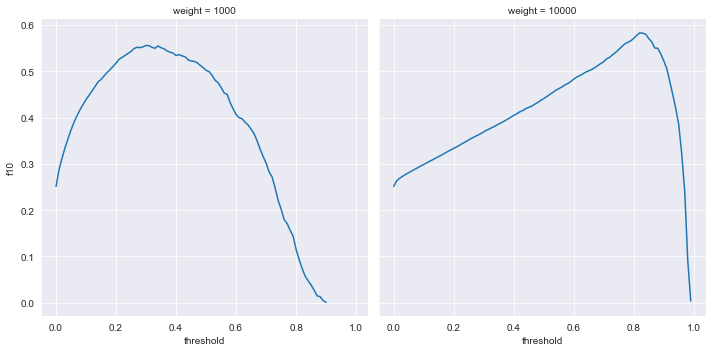

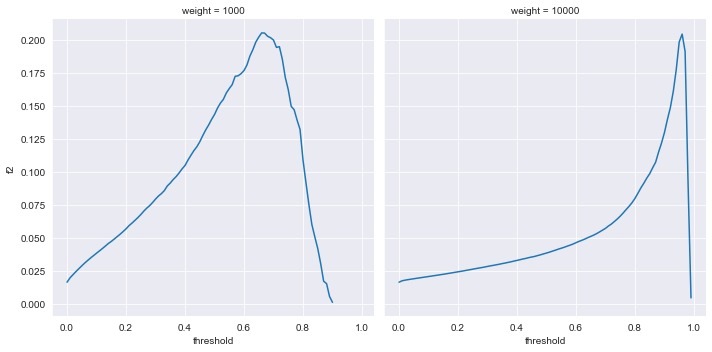

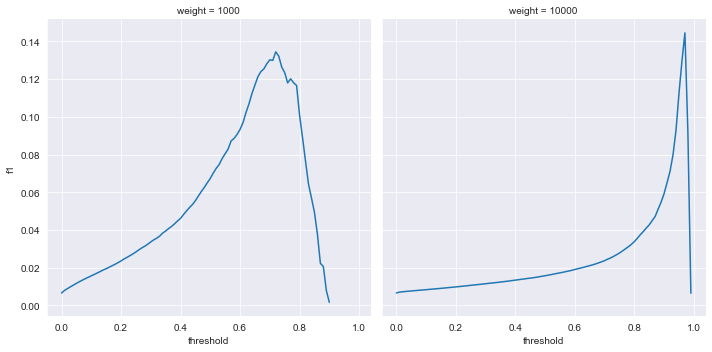

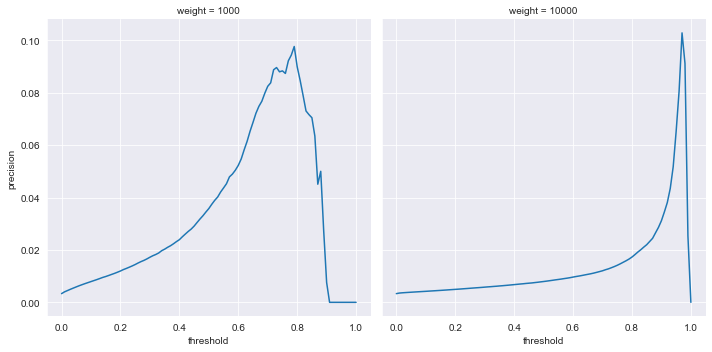

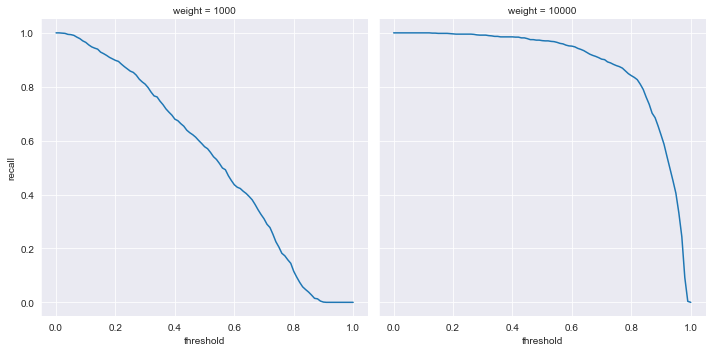

In [65]:
sns.relplot(data=scores_df, kind="line", x="threshold", y="f10", col="weight");
sns.relplot(data=scores_df, kind="line", x="threshold", y="f2", col="weight");
sns.relplot(data=scores_df, kind="line", x="threshold", y="f1", col="weight");
sns.relplot(data=scores_df, kind="line", x="threshold", y="precision", col="weight");
sns.relplot(data=scores_df, kind="line", x="threshold", y="recall", col="weight");

In [66]:
print("Best thresholds, by f1 score")
for weight in [1000, 10000]:
    display(scores_df[scores_df.weight == weight].sort_values(by='f1', ascending=False).head(3))

Best thresholds, by f1 score


,threshold,weight,precision,recall,f1,f2,f10
144,0.72,1000,0.088750,0.277623,0.134503,0.194738,0.271894
146,0.73,1000,0.089592,0.252553,0.132264,0.185185,0.248086
140,0.70,1000,0.082428,0.310121,0.130240,0.199761,0.301865


,threshold,weight,precision,recall,f1,f2,f10
195,0.97,10000,0.102826,0.243268,0.144552,0.191073,0.240022
193,0.96,10000,0.080569,0.331476,0.129630,0.204257,0.321561
191,0.95,10000,0.065240,0.404828,0.112371,0.198344,0.384987


In [67]:
print("Best thresholds, by f2 score")
for weight in [1000, 10000]:
    display(scores_df[scores_df.weight == weight].sort_values(by='f2', ascending=False).head(3))

Best thresholds, by f2 score


,threshold,weight,precision,recall,f1,f2,f10
132,0.66,1000,0.072158,0.380687,0.121320,0.205205,0.365225
134,0.67,1000,0.074790,0.363045,0.124029,0.205013,0.349701
136,0.68,1000,0.076732,0.343547,0.125445,0.202629,0.332113


,threshold,weight,precision,recall,f1,f2,f10
193,0.96,10000,0.080569,0.331476,0.129630,0.204257,0.321561
191,0.95,10000,0.065240,0.404828,0.112371,0.198344,0.384987
195,0.97,10000,0.102826,0.243268,0.144552,0.191073,0.240022


In [68]:
print("Best thresholds, by f10 score")
for weight in [1000, 10000]:
    display(scores_df[scores_df.weight == weight].sort_values(by='f10', ascending=False).head(3))

Best thresholds, by f10 score


,threshold,weight,precision,recall,f1,f2,f10
60,0.30,1000,0.017210,0.809656,0.033704,0.079307,0.556122
62,0.31,1000,0.017785,0.796657,0.034794,0.081637,0.555707
68,0.34,1000,0.019701,0.762303,0.038409,0.089276,0.555127


,threshold,weight,precision,recall,f1,f2,f10
165,0.82,10000,0.019186,0.826369,0.037502,0.087780,0.583372
167,0.83,10000,0.020072,0.809656,0.039173,0.091307,0.582706
169,0.84,10000,0.021065,0.790158,0.041037,0.095177,0.580366


Pearson correlation coefficient: 0.16159237059514692
Pearson correlation coefficient: 0.16071194754280005


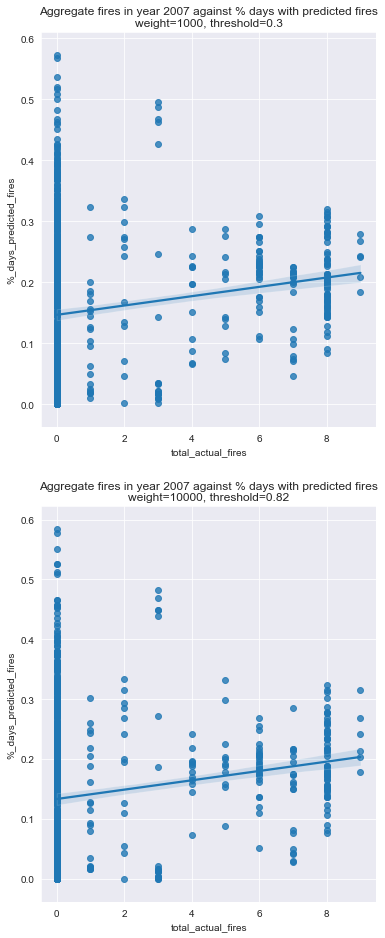

In [81]:
from matplotlib import pyplot as plt

wts = [
    # From f2
#     (1000, 0.66),
#     (1000, 0.67),
#     (1000, 0.68),
#     (10000, 0.96),
#     (10000, 0.95),
#     (10000, 0.97),
    
    # From f10
    (1000, 0.30),
    (10000, 0.82),
]

N = len(wts)
fig, axs = plt.subplots(N, 1, figsize=(6, 8*N))

for i, (weight, threshold) in enumerate(wts):
    mask = complete_df.weight == weight
    tmp = complete_df[mask].copy()
    tmp['prediction'] = tmp.probability_of_fire > threshold 
    yearly_totals_df = tmp.groupby(by=['latitude', 'longitude']).agg(
        total_actual_fires=pd.NamedAgg(column='fire_occurred', aggfunc='sum'),
        total_predicted_fires=pd.NamedAgg(column='prediction', aggfunc='sum'),
    )
    yearly_totals_df['%_days_predicted_fires'] =yearly_totals_df.total_predicted_fires / 365
    pearson = yearly_totals_df.loc[:, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
    print("Pearson correlation coefficient:", pearson)
    ax = axs[i]
    sns.regplot(ax=ax, data=yearly_totals_df, x='total_actual_fires', y='%_days_predicted_fires')
    ax.set_title("Aggregate fires in year {} against % days with predicted fires\n"\
                 "weight={}, threshold={}".format(YEAR, weight, threshold));


## Some observations

There is a slight correlation between the number of predicted fires and the number of actual fires overall.
Can we get better results by restricting our attention to some particular grid locations? For example, do we get good predictions at the most valuable grid locations?

# Economic data

Let's explore the economic data a bit to determine the most valuable grid locations.

In [82]:
econ_df = pd.read_csv('grid_econ_1.csv', index_col=0)
print(econ_df.shape)
econ_df.head()

(507, 10)


,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN


In [83]:
econ_df['total_value'] = np.sum(econ_df[['Val_Struct', 'Val_Cont', 'Val_Other', 'Val_Vehic']], axis=1)
econ_df.head()

,longitude,latitude,Val_Struct,Val_Cont,Val_Other,Val_Vehic,Commercial,Industrial,Public,Residential,total_value
0,-117.600000,33.358333,156566416.6,8.533985e+07,0.0,1.129834e+06,NaN,NaN,1.0,744.0,2.430361e+08
1,-117.600000,33.400000,29536836.2,1.476901e+07,0.0,0.000000e+00,NaN,NaN,NaN,21.0,4.430585e+07
2,-117.558333,33.358333,251410885.4,1.278318e+08,0.0,3.692644e+06,4.0,1.0,1.0,117.0,3.829353e+08
3,-117.558333,33.400000,40361914.8,3.565020e+07,0.0,2.756872e+07,5.0,2.0,12.0,18.0,1.035808e+08
4,-117.516667,33.316667,1807000.0,1.807000e+06,0.0,9.856204e+05,1.0,NaN,1.0,NaN,4.599620e+06


(152, 11)
Pearson correlation coefficient, weight=1000, threshold=0.3: 0.3460286330236112
Pearson correlation coefficient, weight=10000, threshold=0.82: 0.36457587592457447


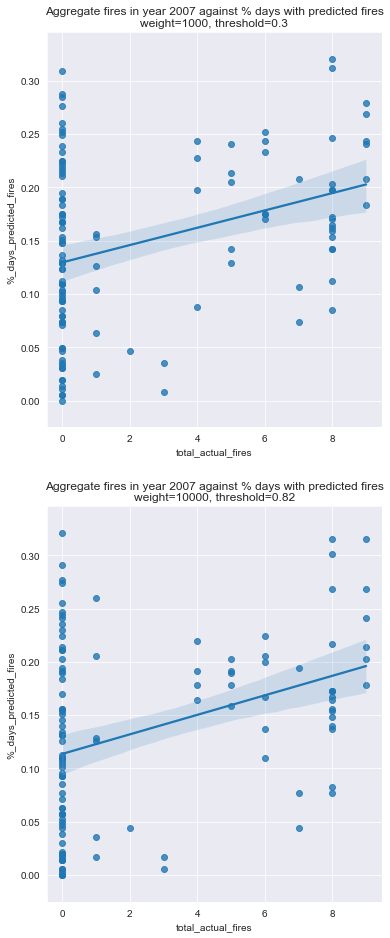

In [85]:
mask = (econ_df.total_value > econ_df.total_value.quantile(0.7))
most_valuable_locations = econ_df[mask]
print(most_valuable_locations.shape)

most_valuable_lons = most_valuable_locations.longitude
most_valuable_lats = most_valuable_locations.latitude

wts = [
    (1000, 0.30),
    (10000, 0.82),
]

N = len(wts)
fig, axs = plt.subplots(N, 1, figsize=(6, 8*N))

for i, (weight, threshold) in enumerate(wts):
    mask = complete_df.weight == weight
    tmp = complete_df[mask].copy()
    tmp['prediction'] = tmp.probability_of_fire > threshold 
    yearly_totals_df = tmp.groupby(by=['latitude', 'longitude']).agg(
        total_actual_fires=pd.NamedAgg(column='fire_occurred', aggfunc='sum'),
        total_predicted_fires=pd.NamedAgg(column='prediction', aggfunc='sum'),
    )
    yearly_totals_df['%_days_predicted_fires'] =yearly_totals_df.total_predicted_fires / 365
    
    yr_mask = (yearly_totals_df.reset_index().latitude.isin(most_valuable_lats) &
       yearly_totals_df.reset_index().longitude.isin(most_valuable_lons))
    pearson = yearly_totals_df.reset_index().loc[yr_mask, ['total_actual_fires', '%_days_predicted_fires']].corr().values[0][1]
    print("Pearson correlation coefficient, weight={}, threshold={}: {}".format(weight, threshold, pearson))
    ax = axs[i]
    sns.regplot(ax=ax, data=yearly_totals_df.reset_index()[yr_mask], x='total_actual_fires', y='%_days_predicted_fires')
    ax.set_title("Aggregate fires in year {} against % days with predicted fires\n"\
                 "weight={}, threshold={}".format(YEAR, weight, threshold));


## Conclusions

There is a modest correlation between predicted fires and the actual number of fires for the most valuable areas. This is a promising result although there is still a clear need for greater precision.